## Adversarial Training

This notebook shows the creation of an adversarial training methodology to harden a neural network against a digital FGSM attack.

### Assumptions
- The dataset wrangling has already been completed (and is provided here)
- The adversarial attack (FGSM) has already been completed
- The outer loop of training has already been completed and we're only subclassing a single epoch
- The plotting code has already been completed

### Components Recreated in Tutorial
- Adversarial training constrained by a power ratio and a percentage of the dataset it alters each epoch.

### See Also
The code in this tutorial is a stripped down version of the code in ``rfml.nn.train.adversarial`` that simplifies discussion.  Further detail can be provided by directly browsing the source files.

In [1]:
# Install the library code
#!pip install git+https://github.com/brysef/rfml.git@1.0

In [2]:
# Ensure that the least loaded GPU is used
import setGPU

# Plotting Includes
import matplotlib.pyplot as plt

# External Includes
import numpy as np

import torch
from torch.autograd import Variable
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

# Internal Includes
from rfml.attack import fgsm

from rfml.data import Dataset, Encoder
from rfml.data import build_dataset

from rfml.nbutils import plot_acc_vs_spr, plot_acc_vs_snr

from rfml.nn.eval import compute_accuracy, compute_accuracy_on_cross_sections
from rfml.nn.model import build_model, Model
from rfml.nn.train import StandardTrainingStrategy, PrintingTrainingListener

setGPU: Setting GPU to: 0


### Configuration

In [3]:
gpu = True       # Set to True to use a GPU for training
fig_dir = None   # Set to a file path if you'd like to save the plots generated
data_path = None # Set to a file path if you've downloaded RML2016.10A locally

## Adversarial Training of a Model

### Load dataset and a DNN model

In [4]:
train, val, test, le = build_dataset("RML2016.10a", path=data_path)
# as_numpy returns x,y and x is shape BxCxIQxN
input_samples = val.as_numpy(le=le)[0].shape[3]
model = build_model(model_name="CNN", input_samples=input_samples, n_classes=len(le))

### Creating our own adversarial trainer

One of the most effective, and simple, methodologies for hardening deep learning models against adversarial attacks is simply "showing" them what they are.  A process known as adversarial training.

Here, we recreate the adversarial training from [Kurakin et al.] that uses the FGSM attack from [Goodfellow et al.] to augment the training examples with adversarial examples.  Note that this coupling of adversarial attack and training was found, in the context of computer vision, to produce robustness which was misleading because it was actually learning to obfuscate the gradient used as a "signal" to create the adversarial example and not necessarily becoming robust to the attack [Tramer et al.].  The adversarial training methodology was then extended to Ensemble Adversarial Training by [Tramer et al.], however, this notebook only demonstrates the adversarial training proposed in [Kurakin et al.] as it can be more easily self-contained into a notebook for demonstration.

Also note that adversarial training was applied in the context of RF in [Kokalj-Filipovic and Miller].

#### Goodfellow et al.
Goodfellow, I., Shlens, J., and Szegedy, C. (2015). Explaining and harnessing adversarial examples. In Int. Conf. on Learning Representations.

#### Kurakin et al.

Kurakin, A., Goodfellow, I. J., and Bengio, S. (2016).  Adversarial machine learning at scale.CoRR, abs/1611.01236.

#### Tramer et. al
Tramer, F., Kurakin, A., Papernot, N., Boneh, D., and McDaniel, P. D. (2017). Ensemble adversarial training: Attacks and defenses.CoRR, abs/1705.07204.

#### Kokalj-Filipovic and Miller

Kokalj-Filipovic, S. and Miller, R. (2019). Adversarial examples in RF deep learning: Detection of the attack and its physical robustness.CoRR, abs/1902.06044.

In [5]:
class MyAdversarialTrainingStrategy(StandardTrainingStrategy):

    def __init__(
        self,
        lr: float = 10e-4,
        max_epochs: int = 50,
        patience: int = 5,
        batch_size: int = 512,
        gpu: bool = True,
        k: float = 0.05,
        spr: float = 10.0,
    ):
        super().__init__(
            lr=lr,
            max_epochs=max_epochs,
            patience=patience,
            batch_size=batch_size,
            gpu=gpu,
        )
        self.k = k
        self.spr = spr

        # The exact value of the sps shouldn't actually matter.  It's simply used for
        # an intermediate scaling of the example before applying the adversarial
        # perturbation with FGSM.  This assumption that it shouldn't matter is based
        # upon the expectation the model does the normalization as the first "layer"
        # in its network.
        self.sps = 8

    def _train_one_epoch(
        self, model: Model, data: DataLoader, loss_fn: CrossEntropyLoss, optimizer: Adam
    ) -> float:
        total_loss = 0.0
        # Switch the model mode so it remembers gradients, induces dropout, etc.
        model.train()

        for i, batch in enumerate(data):
            x, y = batch

            # Perform adversarial augmentation in the training loop using FGSM
            x = self._adversarial_augmentation(x=x, y=y, model=model)

            # Push data to GPU
            if self.gpu:
                x = Variable(x.cuda())
                y = Variable(y.cuda())
            else:
                x = Variable(x)
                y = Variable(y)

            # Forward pass of prediction -- while some are adversarial
            outputs = model(x)

            # Zero out the parameter gradients, because they are cumulative,
            # compute loss, compute gradients (backward), update weights
            loss = loss_fn(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        mean_loss = total_loss / (i + 1.0)
        return mean_loss

    def _adversarial_augmentation(
        self, x: torch.Tensor, y: torch.Tensor, model: Model
    ) -> torch.Tensor:
        # Rely on the fact that the DataLoader shuffles -- therefore can just take the
        # first *n* examples and perform adversarial augmentation on it and it will be
        # a random selection.
        n_adversarial = int(self.k * x.shape[0])
        if n_adversarial == 0:
            return x

        x[0:n_adversarial, ::] = fgsm(
            x=x[0:n_adversarial, ::],
            y=y[0:n_adversarial],
            net=model,
            spr=self.spr,
            sps=self.sps,
        )

        return x

In [6]:
trainer = MyAdversarialTrainingStrategy(max_epochs=10,
                                        patience=3,
                                        gpu=gpu,
                                        k=0.25,
                                        spr=10)
trainer.register_listener(PrintingTrainingListener())
trainer(model=model, training=train, validation=val, le=le)

Epoch 0 completed!
		-Mean Training Loss: 1.566
		-Mean Validation Loss: 1.263
Epoch 1 completed!
		-Mean Training Loss: 1.316
		-Mean Validation Loss: 1.209
Epoch 2 completed!
		-Mean Training Loss: 1.224
		-Mean Validation Loss: 1.204
Epoch 3 completed!
		-Mean Training Loss: 1.129
		-Mean Validation Loss: 1.195
Epoch 4 completed!
		-Mean Training Loss: 1.066
		-Mean Validation Loss: 1.202
Epoch 5 completed!
		-Mean Training Loss: 1.020
		-Mean Validation Loss: 1.251
Epoch 6 completed!
		-Mean Training Loss: 0.977
		-Mean Validation Loss: 1.294
Training has Completed:

	Best Validation Loss: 1.195
	Best Epoch: 3
	Total Epochs: 6


### Testing the Adversarial Trained Model on normal data
This ensures that we haven't completely sacraficed our performance in the baseline case.

In [7]:
acc = compute_accuracy(model=model, data=test, le=le)
print("Overall Testing Accuracy: {:.4f}".format(acc))

Overall Testing Accuracy: 0.5892


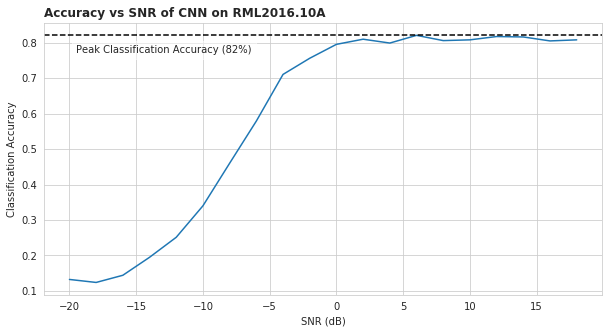

In [8]:
acc_vs_snr, snr = compute_accuracy_on_cross_sections(model=model,
                                                     data=test,
                                                     le=le,
                                                     column="SNR")

title = "Accuracy vs SNR of {model_name} on {dataset_name}".format(model_name="CNN", dataset_name="RML2016.10A")
fig = plot_acc_vs_snr(acc_vs_snr=acc_vs_snr, snr=snr, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/hardened_acc_vs_snr.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### Verifying the Model has been Hardened
Attempt Evading Signal Classification with Direct Access to the Classifier again to see if we have improved over our prior attack.

In [9]:
mask = test.df["SNR"] >= 18
dl = DataLoader(test.as_torch(le=le, mask=mask), shuffle=True, batch_size=512)

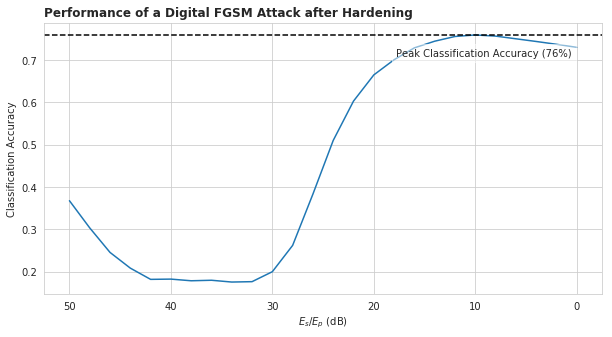

In [10]:
# Ensure that the model is in "evaluation" mode
# -- Therefore batch normalization is not computed and dropout is not performed
# -- Note: This is the cause of a lot of bugs
model.eval()

acc_vs_spr = list()
sprs = list()

for spr in np.linspace(50.0, 0.0, num=26):
    right = 0
    total = 0
    
    for x, y in dl:
        adv_x = fgsm(x, y, spr=spr, input_size=input_samples, sps=8, net=model)

        predictions = model.predict(adv_x)
        right += (predictions == y).sum().item()
        total += len(y)

    acc = float(right) / total
    acc_vs_spr.append(acc)
    sprs.append(spr)

fig = plot_acc_vs_spr(acc_vs_spr=acc_vs_spr,
                      spr=sprs,
                      title="Performance of a Digital FGSM Attack after Hardening"
                     )
if fig_dir is not None:
    file_path = "{fig_dir}/hardened_direct_access_fgsm.pdf".format(fig_dir=fig_dir)
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()